**TITANIC DATASET**

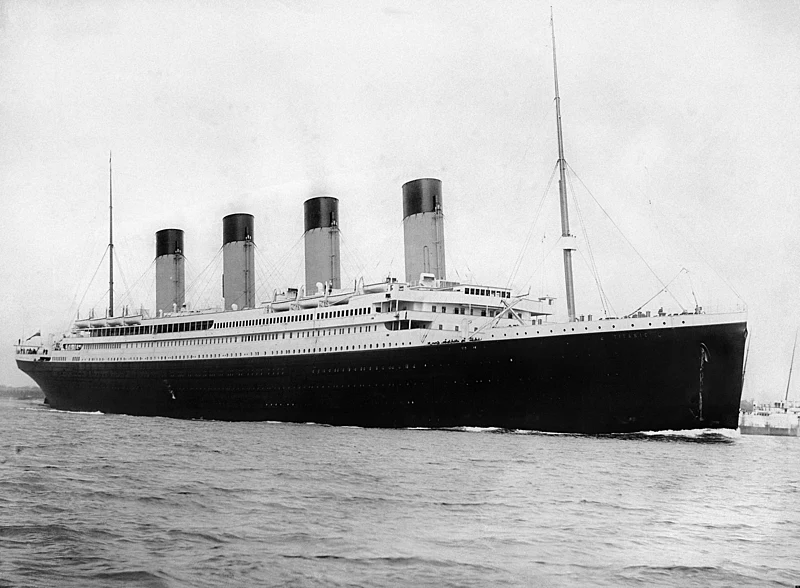

# **Columns Definitions**

| Column Name | Definition |
| --- | --- |
| Survived | Whether Survived or not: 0 = No, 1 = Yes |
| Pclass | Ticket class: 1 = 1st, 2 = 2nd, 3 = 3rd |
| Name | Name of the Passenger |
| Sex | Gender |
| Age | Age in Years |
| SibSp | No. of siblings / spouses aboard the Titanic |
| Parch | No. of parents / children aboard the Titanic |
| Ticket | Ticket number |
| Fare | Passenger fare |
| Cabin | Cabin number |
| Embarked | Port of Embarkation:C = Cherbourg, Q = Queenstown, S = Southampton |

# **Description**

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone on board, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

# **Objective**

- Understand the Dataset & cleanup (if required).
- Build a strong classification model to predict whether the passenger survives or not.
- Also fine-tune the hyperparameters & compare the evaluation metrics of various classification algorithms.

# **Library**

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d 'yasserh/titanic-dataset'
!unzip titanic-dataset.zip -d titanic_data

Saving kaggle.json to kaggle.json
  0% 0.00/22.0k [00:00<?, ?B/s]
100% 22.0k/22.0k [00:00<00:00, 36.7MB/s]
Archive:  titanic-dataset.zip
  inflating: titanic_data/Titanic-Dataset.csv  


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from sklearn.preprocessing import LabelEncoder

# Sidetable
!pip install sidetable
import sidetable as stb

# Scaler
from sklearn.preprocessing import normalize,StandardScaler

# Encoder
from sklearn.preprocessing import LabelEncoder

# Train Test Split
from sklearn.model_selection import train_test_split

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Classification Metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,roc_auc_score,classification_report,log_loss

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.decomposition import PCA

# Optimiser
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
!pip install scikit-optimize
from skopt import BayesSearchCV
!pip install hyperopt
from hyperopt import fmin, tpe, hp, Trials
!pip install optuna
import optuna

# Styler
def highlight_nans(val):
    color = 'red' if pd.isna(val) else ''
    return f'background-color: {color}'
from IPython.display import clear_output

# Max Columns Viewer
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output
clear_output()

# **EDA**

Data preparation begins with loading detailed titanic datasets, which invloves reading CSV files containing information about name, sex, age specifics. Initial steps include assessing the structure and completeness of the data

## **Dataset**

In [85]:
# read 'Titanic-Dataset.csv'
df = pd.read_csv('titanic_data/Titanic-Dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [72]:
# investigate shape
df.shape

(891, 12)

In [73]:
# investigate columns length and type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [74]:
# investigate columns that consist null values
df_isna = df.isna().sum()
df_isna[df_isna > 0]

Age         177
Cabin       687
Embarked      2
dtype: int64

The data loaded shows to have a shape of 891 rows and 12 columns, with several of its columns contain null values like 'Age', 'Cabin', and 'Embarked'. Transformation required will be conducted after the exploration.

## **Unique Values**

In [75]:
# Investigate unique values in each column
df_str = df.copy()
for i in df_str.columns:
    df_str[i] = df_str[i].apply(lambda x: str(x))
df_str.replace('nan',np.nan,inplace=True)

df_str.describe(include='object').T.sort_values(by='unique', ascending=False)

,count,unique,top,freq
PassengerId,891,891,1,1
Name,891,891,"Braund, Mr. Owen Harris",1
Ticket,891,681,347082,7
Fare,891,248,8.05,43
Cabin,204,147,B96 B98,4
Age,714,88,24.0,30
SibSp,891,7,0,608
Parch,891,7,0,678
Pclass,891,3,3,491
Embarked,889,3,S,644


- 3 top columns, 'PassengerID', 'Name', 'Ticket', are going to be dropped due to its high number in unique values.
- 'Fare' and 'Age' high number of unique values are due to its columns' numerical type.
- 'Cabin' column will also be dropped due to the high number of missing values. Dropping will be conducted on the next section.

## **Unnecessary Columns Dropping**

In [76]:
# create new df and drop columns
df = df.drop(columns=[
    # too many unique values
    'PassengerId','Name','Ticket',
    # too many null values
    'Cabin'])
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## **Visualisation**

In [77]:
# unique value numbers in each columns after dropping
df_str = df.copy()
for i in df_str.columns:
  df_str[i] = df_str[i].apply(lambda x:str(x))
df_str.replace('nan',np.nan,inplace=True)

df_unique = df_str.describe(include='object').T.sort_values(by='unique',ascending=False)
df = df[df_unique.index]
df_unique

,count,unique,top,freq
Fare,891,248,8.05,43
Age,714,88,24.0,30
SibSp,891,7,0,608
Parch,891,7,0,678
Pclass,891,3,3,491
Embarked,889,3,S,644
Survived,891,2,0,549
Sex,891,2,male,577


- The categorical columns will be visualised by barplot, while its correlation to each other will be visualised by heatmap
- The numerical columns will be visualised by histogram and boxplot, while its correlation to each other will be visualised by scatterplot

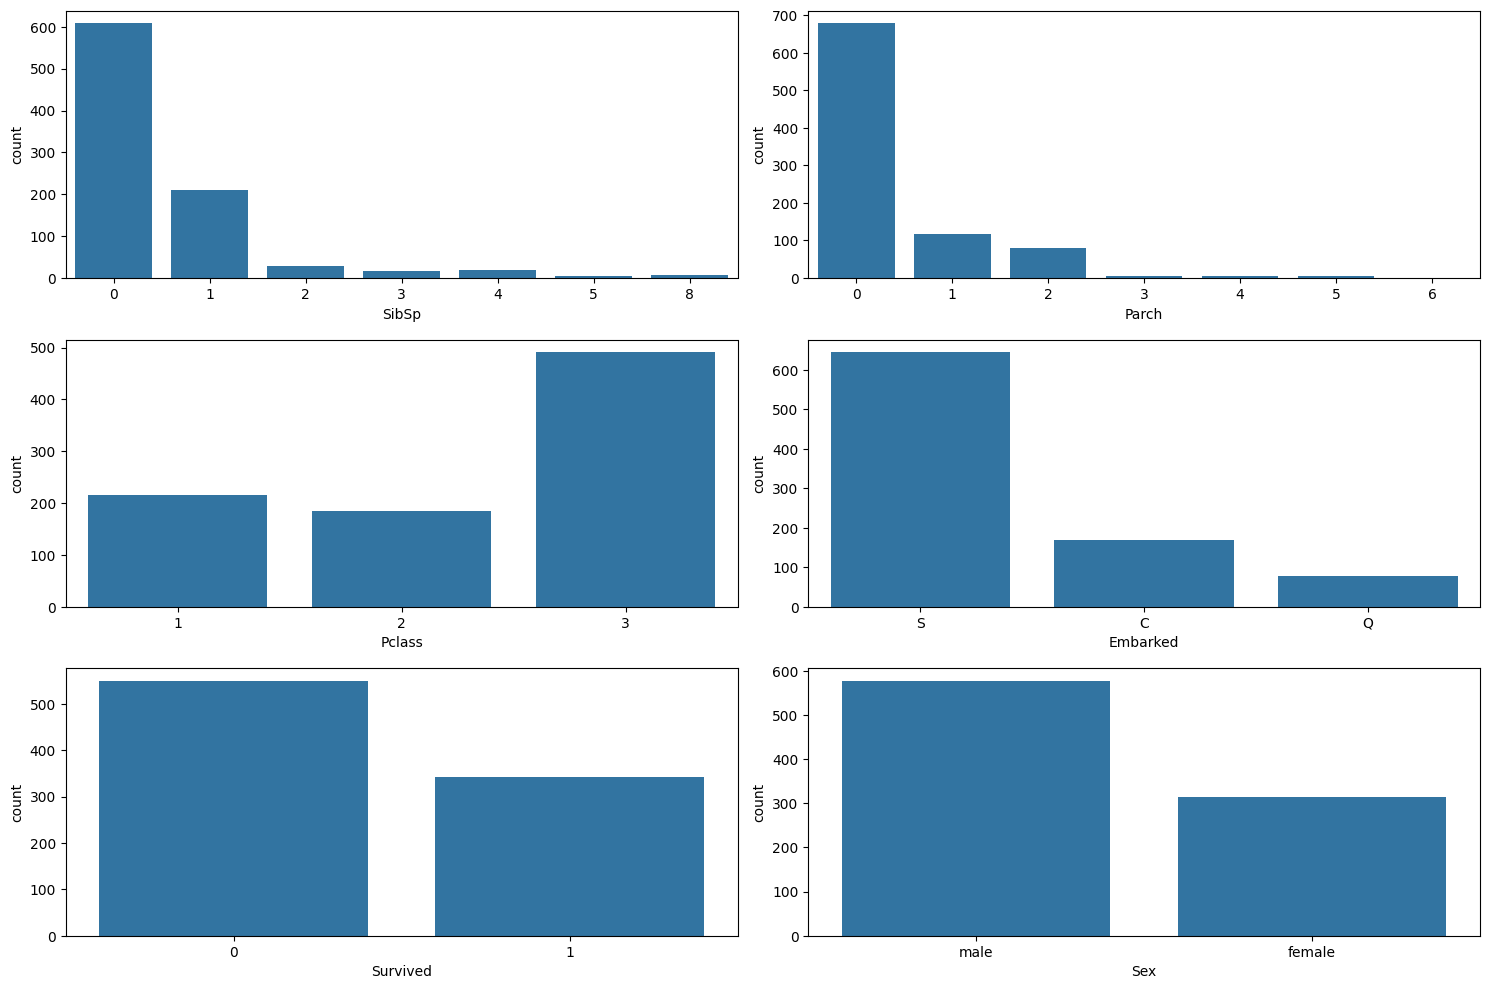

In [78]:
# visualise categorical columns
fig,axes=plt.subplots(3,2,figsize=(15,10))
sns.countplot(data=df,x=df.columns[2],ax=axes[0,0])
sns.countplot(data=df,x=df.columns[3],ax=axes[0,1])
sns.countplot(data=df,x=df.columns[4],ax=axes[1,0])
sns.countplot(data=df,x=df.columns[5],ax=axes[1,1])
sns.countplot(data=df,x=df.columns[6],ax=axes[2,0])
sns.countplot(data=df,x=df.columns[7],ax=axes[2,1])
plt.tight_layout()

<Axes: >

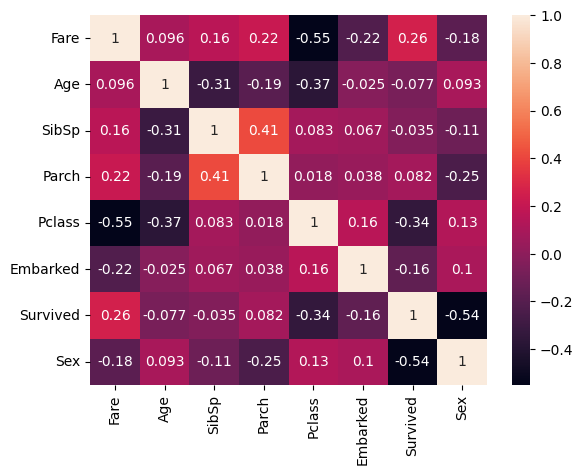

In [79]:
# correlation of each columns
cat_encs = ['Embarked','Sex']

le = LabelEncoder()

df_cat = df.copy()

for i in cat_encs:
  df_cat[i] = le.fit_transform(df_cat[i])

sns.heatmap(df_cat.corr(),annot=True)

Correlation of each column are low to nothing, none has any significant correlation

In [80]:
# correlation of each column to the target column
pd.DataFrame(df_cat.corr()['Survived']).sort_values(by='Survived',ascending=False).iloc[1:]

,Survived
Fare,0.257307
Parch,0.081629
SibSp,-0.035322
Age,-0.077221
Embarked,-0.163517
Pclass,-0.338481
Sex,-0.543351


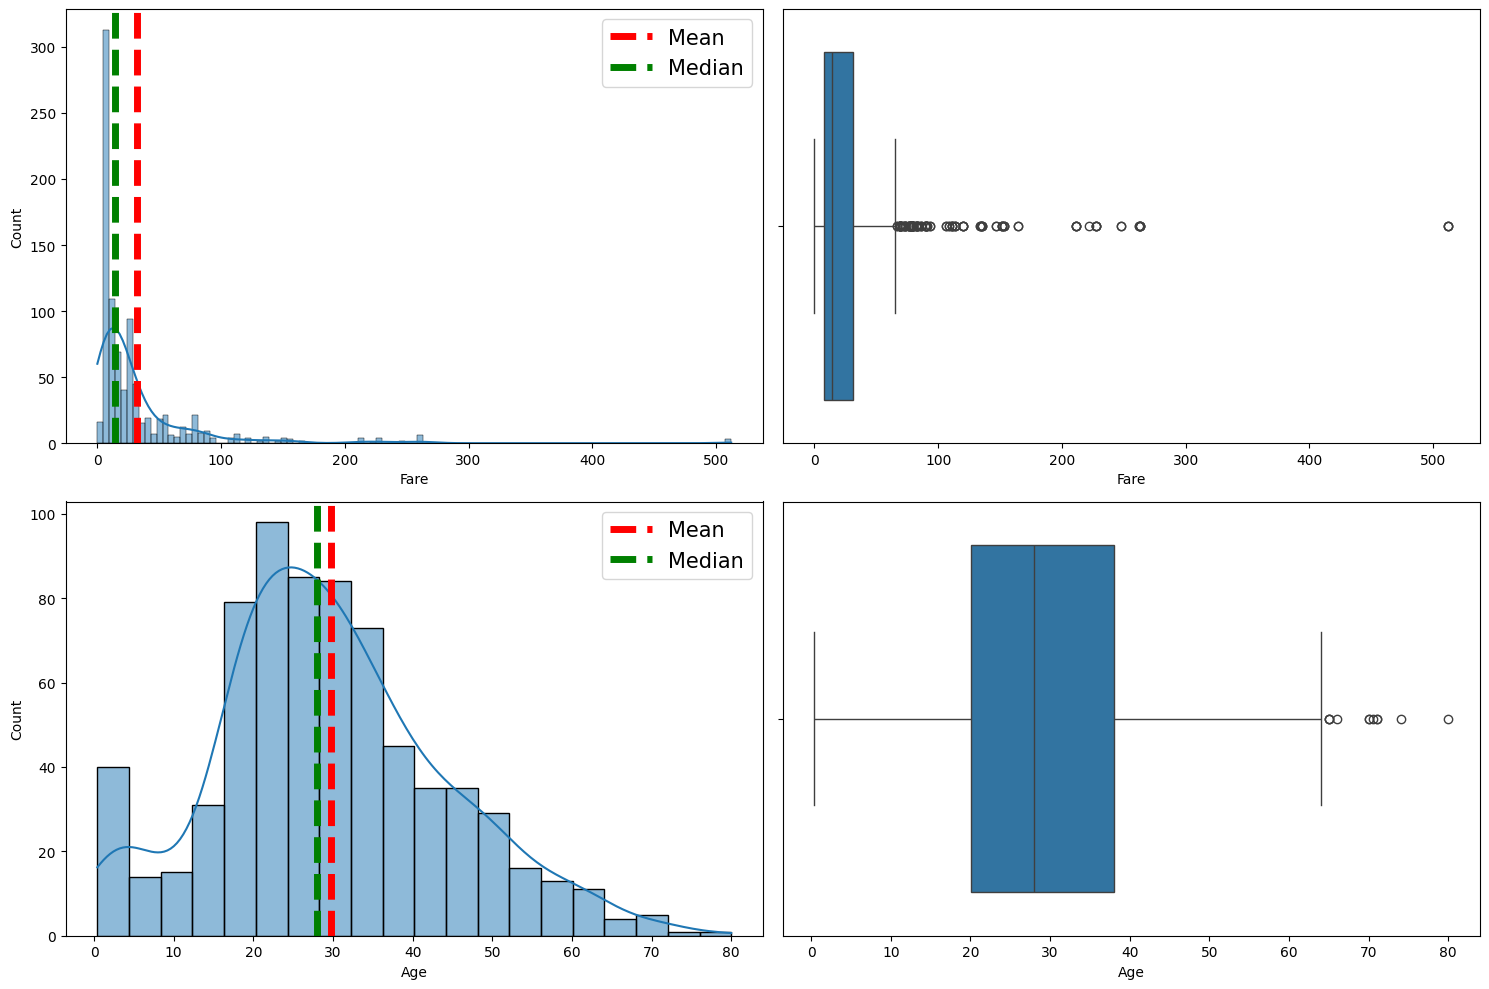

In [81]:
# visualise numerical columns
fig,axes=plt.subplots(2,2,figsize=(15,10))
sns.histplot(data=df,x=df.columns[0],kde=True,ax=axes[0,0])
axes[0,0].axvline(df[df.columns[0]].mean(),color='red',linestyle='--',linewidth=5,label='Mean')
axes[0,0].axvline(df[df.columns[0]].median(),color='green',linestyle='--',linewidth=5,label='Median')
axes[0,0].legend(fontsize=15)
sns.boxplot(data=df,x=df.columns[0],ax=axes[0,1])

sns.histplot(data=df,x=df.columns[1],kde=True,ax=axes[1,0])
axes[1,0].axvline(df[df.columns[1]].mean(),color='red',linestyle='--',linewidth=5,label='Mean')
axes[1,0].axvline(df[df.columns[1]].median(),color='green',linestyle='--',linewidth=5,label='Median')
axes[1,0].legend(fontsize=15)
sns.boxplot(data=df,x=df.columns[1],ax=axes[1,1])
plt.tight_layout()

Both of the columns contain outliers, however, 'Fare' column has extreme outliers, therefore, treatment will only be conducted to the outliers in the 'Fare' column.

<Axes: xlabel='Fare', ylabel='Age'>

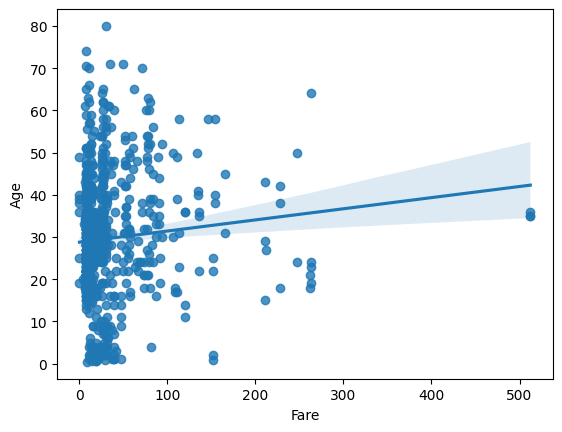

In [82]:
# correlation of each numerical columns
sns.regplot(data=df,x='Fare',y='Age')

as mentioned earlier, the correlation scored 0.096, very weak

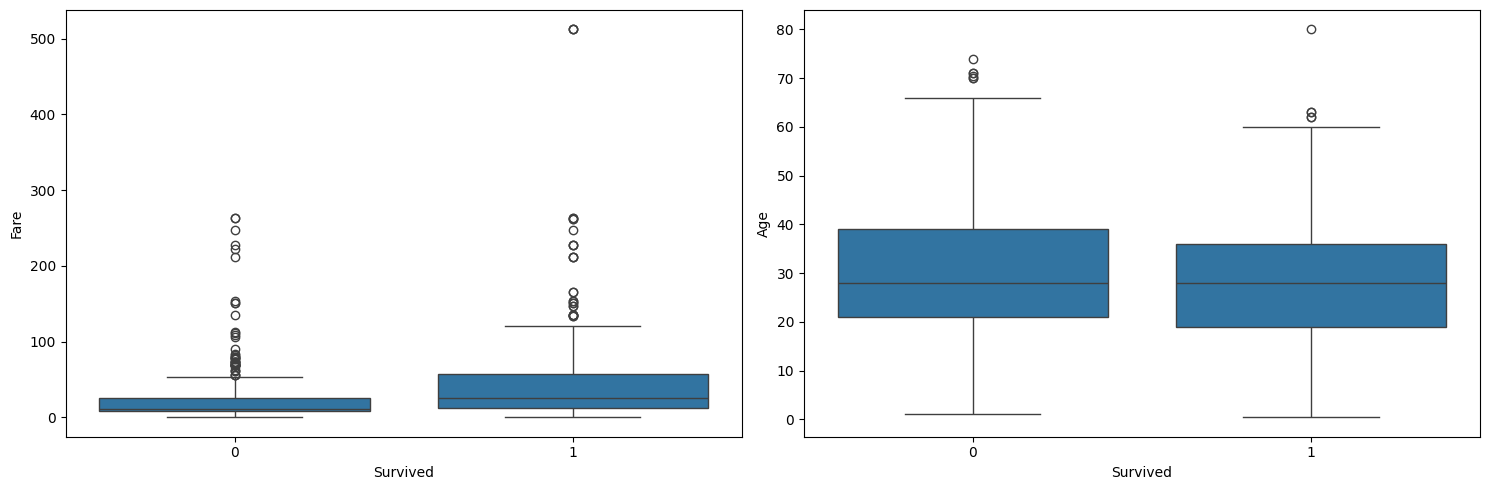

In [83]:
# correlation of each numerical column to the target column
fig,axes=plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df,x=df.columns[6],y=df.columns[0],ax=axes[0])
sns.boxplot(data=df,x=df.columns[6],y=df.columns[1],ax=axes[1])
plt.tight_layout()

The boxplot of 'Fare' and 'Survived' above shows that the extreme outliers to be in the 'survived' category (1). The details are shown below.

In [92]:
# inspect the outliers in 'Fare' columns
Q1 = df['Fare'].quantile(0.25)
Q3 = df['Fare'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Fare'] < lower_bound) | (df['Fare'] > upper_bound)]
df = df[(df['Fare'] >= lower_bound) & (df['Fare'] <= upper_bound)]
outliers.sort_values(by='Fare',ascending=False).head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S


As seen above, the extreme value is shown to be way higher than the others, confirming it's extreme outliers status.

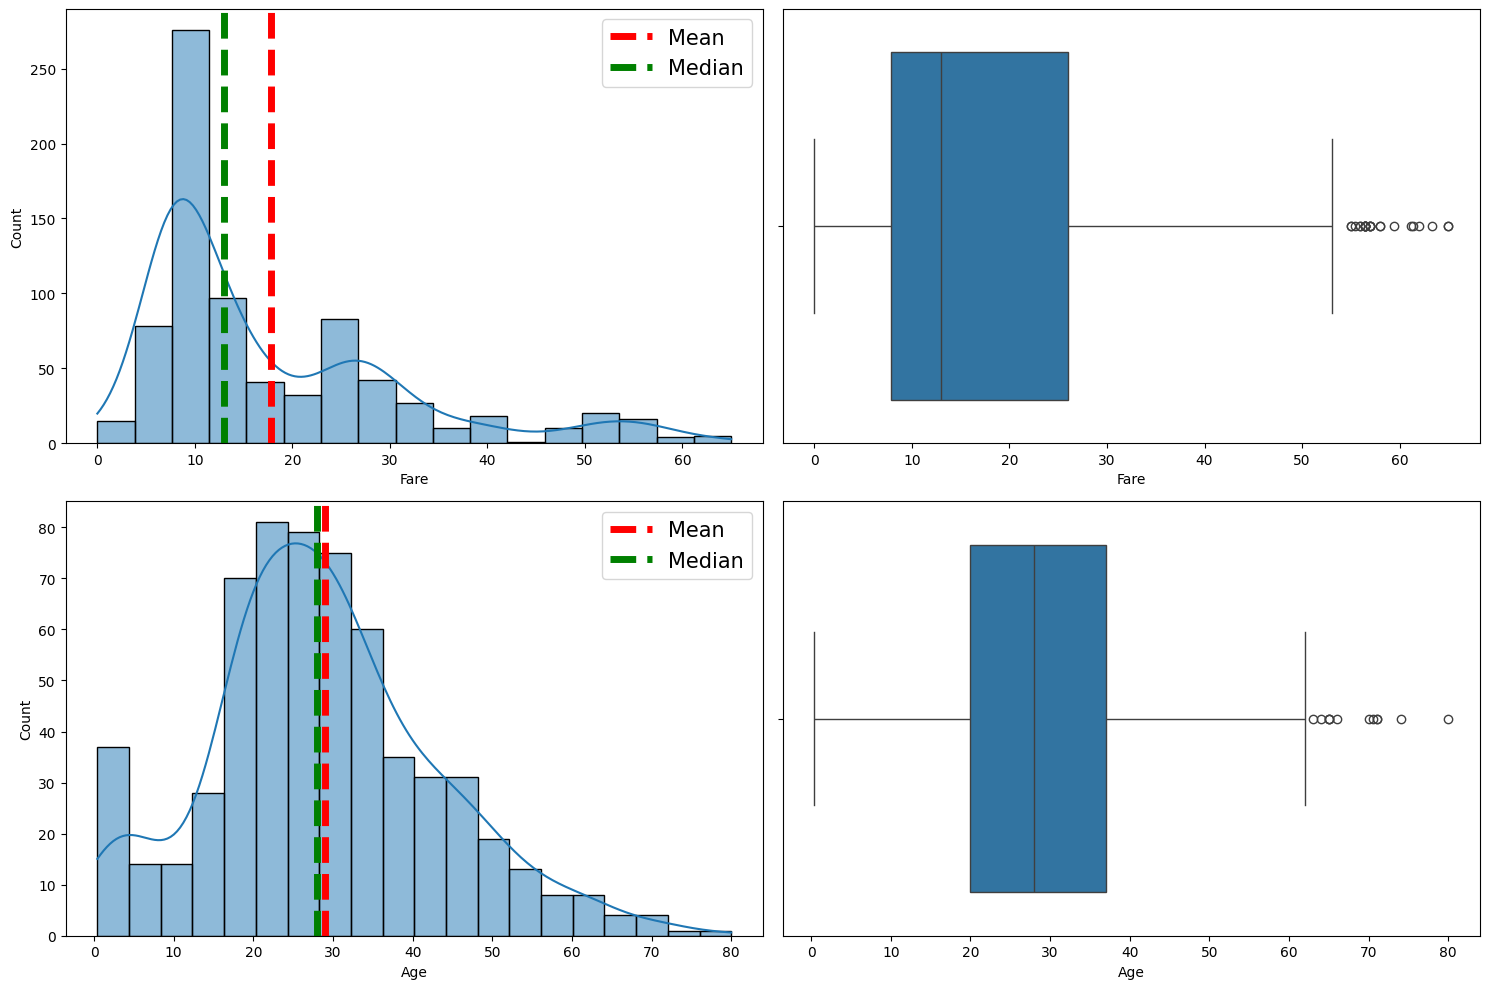

In [16]:
# visualised the data after the outliers dropping
fig,axes=plt.subplots(2,2,figsize=(15,10))
sns.histplot(data=df,x=df.columns[0],kde=True,ax=axes[0,0])
axes[0,0].axvline(df[df.columns[0]].mean(),color='red',linestyle='--',linewidth=5,label='Mean')
axes[0,0].axvline(df[df.columns[0]].median(),color='green',linestyle='--',linewidth=5,label='Median')
axes[0,0].legend(fontsize=15)
sns.boxplot(data=df,x=df.columns[0],ax=axes[0,1])

sns.histplot(data=df,x=df.columns[1],kde=True,ax=axes[1,0])
axes[1,0].axvline(df[df.columns[1]].mean(),color='red',linestyle='--',linewidth=5,label='Mean')
axes[1,0].axvline(df[df.columns[1]].median(),color='green',linestyle='--',linewidth=5,label='Median')
axes[1,0].legend(fontsize=15)
sns.boxplot(data=df,x=df.columns[1],ax=axes[1,1])

plt.tight_layout()

<Axes: xlabel='Fare', ylabel='Age'>

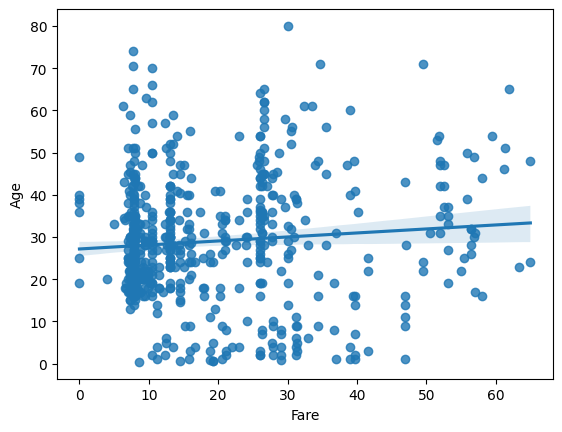

In [17]:
# correlation of the numerical columns after the outlier dropping
sns.regplot(data=df,x='Fare',y='Age')

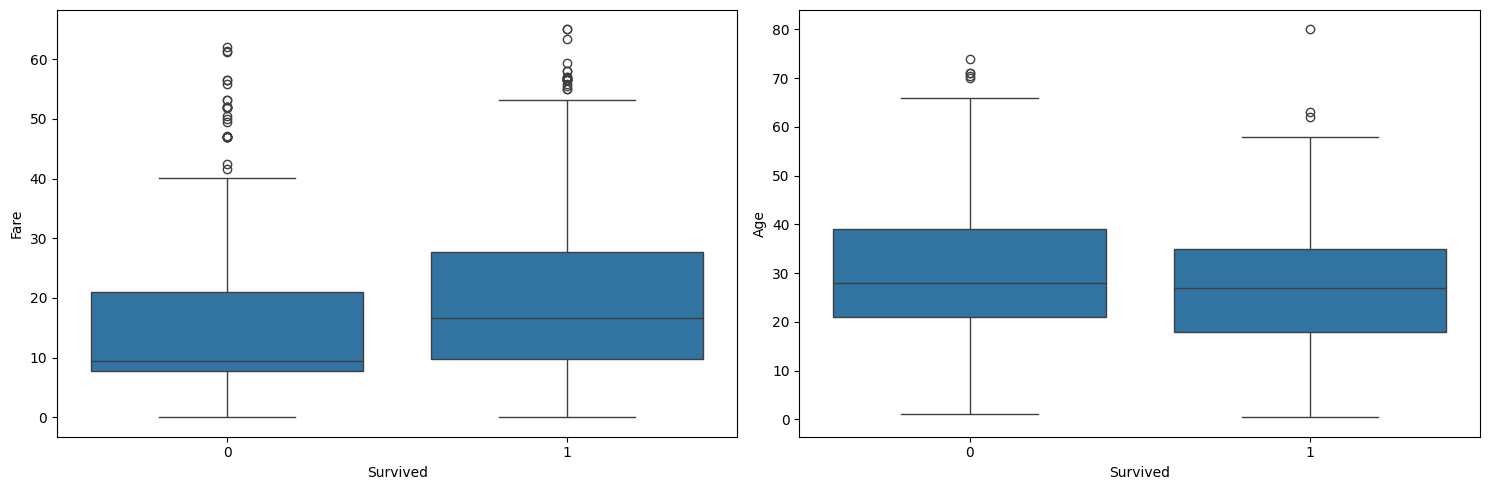

In [18]:
# correlation of each numerical column to the target column after the
# outlier dropping
fig,axes=plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df,x=df.columns[6],y=df.columns[0],ax=axes[0])
sns.boxplot(data=df,x=df.columns[6],y=df.columns[1],ax=axes[1])
plt.tight_layout()

Despite the outliers are still there, the visualisation looks much better now and will be  normalize.

## **Imputation**

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 775 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Fare      775 non-null    float64
 1   Age       613 non-null    float64
 2   SibSp     775 non-null    int64  
 3   Parch     775 non-null    int64  
 4   Embarked  775 non-null    object 
 5   Pclass    775 non-null    int64  
 6   Survived  775 non-null    int64  
 7   Sex       775 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 54.5+ KB


after outlier dropping, the number of null values had decreased to only the 'Age' column contains it. The details are show below.

In [20]:
df[df['Age'].isna()].head()

,Fare,Age,SibSp,Parch,Embarked,Pclass,Survived,Sex
5,8.4583,NaN,0,0,Q,3,0,male
17,13.0000,NaN,0,0,S,2,1,male
19,7.2250,NaN,0,0,C,3,1,female
26,7.2250,NaN,0,0,C,3,0,male
28,7.8792,NaN,0,0,Q,3,1,female


Based on the visualisation before, the numerical columns distributions are mostly right-skewed. Therefore, the null values will be replaced by the columns' median.

In [21]:
df['Age'].fillna(df['Age'].median(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 775 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Fare      775 non-null    float64
 1   Age       775 non-null    float64
 2   SibSp     775 non-null    int64  
 3   Parch     775 non-null    int64  
 4   Embarked  775 non-null    object 
 5   Pclass    775 non-null    int64  
 6   Survived  775 non-null    int64  
 7   Sex       775 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 54.5+ KB


# **Train Test Split**

Now that the data has been cleaned, next, the data will be split into train and test data

In [23]:
# split the data into train and test
X = df.drop(columns=['Survived'])
y = df[['Survived']]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=7)

# encode the categorical columns
cat_encs = ['Embarked','Sex']

le = LabelEncoder()

for col in cat_encs:
    le.fit(df[col])
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

# scale the data with normalize function
X_train_normalized = normalize(X_train)
X_test_normalized = normalize(X_test)

X_train = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test = pd.DataFrame(X_test_normalized, columns=X_test.columns)

# **Machine Learning**

## **Model Selection and Development**

Since the aim of this analysis is to predict if the observed individual survived the tragedy or not, 'Survived' column will be the target variable.

In [24]:
# target variable unique value counts
y_train.stb.freq(['Survived'])

,Survived,count,percent,cumulative_count,cumulative_percent
0,0,403,65.0,403,65.0
1,1,217,35.0,620,100.0


Several machine learning models were utilised to predict the severity of the accident, such as:

- Decision Tree : a supervised model that is easily interpreted that has tree-like structure allowing better decision making by spliting the features,
- Random Forest : An ensemble model tha developed several decision trees to increase accuracy and avoid overfitting in the prediction,
- Gradient Boosting : another ensemble model that is more powerful due to its ability to correct the previous trees' errors,
- XGBoost : an optimised gradient boosting, used for its efficiency and scalability
- LightGBM : another gradient boosting model that is faster and more efficient,
- CatBoost : a gardient boosting that works well with categorical features and able to handle missing values,
- Naive Bayes : the based-line classifier model based on the Bayesian theorem


Also, multiple classification metrics were employed to assess the models' performance, like:

- Accuracy : compares the predicted values and the actual observations to measure the overall model's correctness,
- Precision : the predictions true positive ratio to the positive predictions total to showcase the model's false positive avoiding ability,
- Recall: true positive predictions ratio to the actual positive total
- F1s : offers the precision and recall's mean when the data is imbalance,
- ROC AUC : the model's classes distinguishing ability accross the thresholds ability measurement
- logloss : the model's uncertainty measurement in predictions

The above table shows a huge imblance in the target variable, thus, based on the above explanation, F1 score will be the primary metric to assess the model's performance

In [25]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(silent=True,random_state=42),
    'Naive Bayes': GaussianNB(),
}

accuracies = []
precisions = []
recalls = []
f1s = []
roc_aucs = []
loglosses = []
durs = []

for name, model in models.items():
    start = datetime.now()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end = datetime.now()
    dur = str(end-start)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    logloss = log_loss(y_test, y_pred)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    roc_aucs.append(roc_auc)
    loglosses.append(logloss)
    durs.append(dur)

clear_output()

In [26]:
model_df = pd.DataFrame({'Model Name':models.keys(),
                         'Accuracies':accuracies,
                         'Precisions':precisions,
                         'Recall':recalls,
                         'F1s':f1s,
                         'ROC AUX':roc_aucs,
                         'Loglosses':loglosses,
                         'Durations':durs})
model_df = model_df.sort_values(by='F1s',ascending=False).reset_index(drop=True)
model_df

,Model Name,Accuracies,Precisions,Recall,F1s,ROC AUX,Loglosses,Durations
0,CatBoost,0.819355,0.783606,0.783606,0.783606,0.783606,6.511112,0:00:06.169192
1,Random Forest,0.806452,0.768095,0.780714,0.773657,0.780714,6.976191,0:00:00.501658
2,Gradient Boosting,0.806452,0.767913,0.774432,0.770981,0.774432,6.976191,0:00:00.466466
3,LightGBM,0.800000,0.760343,0.763562,0.761905,0.763562,7.208731,0:00:00.347207
4,XGBoost,0.787097,0.747595,0.766953,0.755134,0.766953,7.673810,0:00:01.046957
5,Decision Tree,0.767742,0.723810,0.734344,0.728388,0.734344,8.371429,0:00:00.017975
6,Naive Bayes,0.741935,0.687500,0.672018,0.678156,0.672018,9.301588,0:00:00.006370


The above table shows the performance of each model according to its metrics. Overall, CatBoost is the highest performing model with accuracy of 81.94%, precision of 78.36%, recall of 78.36%, F1 score of 78.36%, ROC AUX of 78.36%, logloss of 6.51, and a decent amount of development duration of 6 seconds. All in all, most of the model returned results within the acceptable range of 70-90%, even the baseline model, Naive Bayes.

# **Feature Selection**

## **Feat Improtance**

Next, each feature importance was inspected, which shows the relative importance of each feature to the dependent variable. The highest importance goes to "Sex" with 29.5937 importance score.

In [27]:
feat_imp = pd.DataFrame({"Columns Name":X_train.columns,
                         "Feature Importance":models[model_df.iloc[0,0]].feature_importances_})
feat_imp = feat_imp.sort_values(by='Feature Importance',ascending=False).reset_index(drop=True)
feat_imp

,Columns Name,Feature Importance
0,Sex,29.593653
1,Pclass,16.455820
2,Embarked,14.376080
3,Fare,11.638663
4,Age,11.529242
5,SibSp,9.944978
6,Parch,6.461565


In the next section each feature combinations will be observed according to the importance of each variable.

In [28]:
featimp_accuracies = []
featimp_precisions = []
featimp_recalls = []
featimp_f1s = []
featimp_roc_aucs = []
featimp_loglosses = []

for i in range(1,df.shape[1]+1):
  feat_imp_col = feat_imp.iloc[:i,0]

  model = CatBoostClassifier(silent=True,random_state=42)
  model.fit(X_train[feat_imp_col], y_train)
  y_pred = model.predict(X_test[feat_imp_col])

  featimp_accuracy = accuracy_score(y_test, y_pred)
  featimp_precision = precision_score(y_test, y_pred, average='macro')
  featimp_recall = recall_score(y_test, y_pred, average='macro')
  featimp_f1 = f1_score(y_test, y_pred, average='macro')
  featimp_cm = confusion_matrix(y_test, y_pred)
  featimp_roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
  featimp_report = classification_report(y_test, y_pred)
  featimp_logloss = log_loss(y_test, y_pred)

  featimp_accuracies.append(featimp_accuracy)
  featimp_precisions.append(featimp_precision)
  featimp_recalls.append(featimp_recall)
  featimp_f1s.append(featimp_f1)
  featimp_roc_aucs.append(featimp_roc_auc)
  featimp_loglosses.append(featimp_logloss)

clear_output()

In [29]:
model_df_featImp = pd.DataFrame({'Cols Num':[i for i in range(1,df.shape[1]+1)],
                                 'Accuracies':featimp_accuracies,
                                 'Precisions':featimp_precisions,
                                 'Recall':featimp_recalls,
                                 'F1s':featimp_f1s,
                                 'ROC AUX':featimp_roc_aucs,
                                 'Loglosses':featimp_loglosses})
model_df_featImp = model_df_featImp.sort_values(by='F1s',ascending=False).reset_index(drop=True)
model_df_featImp

,Cols Num,Accuracies,Precisions,Recall,F1s,ROC AUX,Loglosses
0,3,0.832258,0.800573,0.792780,0.796465,0.792780,6.046032
1,2,0.825806,0.790335,0.800758,0.795104,0.800758,6.278572
2,4,0.819355,0.783002,0.789888,0.786249,0.789888,6.511112
3,5,0.812903,0.775414,0.785301,0.779927,0.785301,6.743651
4,7,0.806452,0.767913,0.774432,0.770981,0.774432,6.976191
5,8,0.806452,0.767913,0.774432,0.770981,0.774432,6.976191
6,6,0.800000,0.761029,0.776127,0.767436,0.776127,7.208731
7,1,0.774194,0.733259,0.751496,0.740294,0.751496,8.138889


According to the Feature Importance, 3 columns combination returns the best results, and it improve the overal result of the model.

## SelectKBest

Next, feature selection was conducted using SelectKBest, with r_regression as the scoring function to try every possible variable combinations.

In [30]:
selectKBest_accuracies = []
selectKBest_precisions = []
selectKBest_recalls = []
selectKBest_f1s = []
selectKBest_roc_aucs = []
selectKBest_loglosses = []

for i in range(1,df.shape[1]):
  selector = SelectKBest(r_regression, k=i)
  selectKBest_Xtrain = selector.fit_transform(X_train, y_train)
  selectKBest_Xtest = selector.transform(X_test)

  model = RandomForestClassifier(random_state=42)
  model.fit(selectKBest_Xtrain, y_train)
  y_pred = model.predict(selectKBest_Xtest)

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')
  f1 = f1_score(y_test, y_pred, average='macro')
  roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
  report = classification_report(y_test, y_pred)
  logloss = log_loss(y_test, y_pred)

  selectKBest_accuracies.append(accuracy)
  selectKBest_precisions.append(precision)
  selectKBest_recalls.append(recall)
  selectKBest_f1s.append(f1)
  selectKBest_roc_aucs.append(roc_auc)
  selectKBest_loglosses.append(logloss)

clear_output()

In [31]:
model_df_selectKBest = pd.DataFrame({'Cols Num':[i for i in range(1,df.shape[1])],
                                     'Accuracies':selectKBest_accuracies,
                                     'Precisions':selectKBest_precisions,
                                     'Recall':selectKBest_recalls,
                                     'F1s':selectKBest_f1s,
                                     'ROC AUX':selectKBest_roc_aucs,
                                     'Loglosses':selectKBest_loglosses})
model_df_selectKBest = model_df_selectKBest.sort_values(by='F1s',ascending=False).reset_index(drop=True)
model_df_selectKBest

,Cols Num,Accuracies,Precisions,Recall,F1s,ROC AUX,Loglosses
0,7,0.806452,0.768095,0.780714,0.773657,0.780714,6.976191
1,5,0.748387,0.696192,0.682888,0.688418,0.682888,9.069048
2,4,0.709677,0.651010,0.649083,0.650008,0.649083,10.464286
3,6,0.709677,0.646448,0.636518,0.640482,0.636518,10.464286
4,1,0.664516,0.605714,0.610690,0.607671,0.610690,12.092064
5,3,0.658065,0.588384,0.587256,0.587787,0.587256,12.324604
6,2,0.632258,0.552118,0.550060,0.550816,0.550060,13.254763


According to the SelectKBest, 7 columns combination returns the best results, however, the original model returned a better result than SelectKBest.

## PRINCIPAL COMPONENT ANALYSIS (PCA)

Subsequently, another feature selection method called Principal Component Analysis (PCA) was leveraged to help reduce the dimensionality of the data, helping with complexity simplication.

In [32]:
PCA_accuracies = []
PCA_precisions = []
PCA_recalls = []
PCA_f1s = []
PCA_roc_aucs = []
PCA_loglosses = []

for i in range(1,df.shape[1]):
  pca = PCA(n_components=i)
  PCA_Xtrain = pca.fit_transform(X_train)
  PCA_Xtest = pca.transform(X_test)

  model = RandomForestClassifier(random_state=42)
  model.fit(PCA_Xtrain, y_train)
  y_pred = model.predict(PCA_Xtest)

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='macro')
  recall = recall_score(y_test, y_pred, average='macro')
  f1 = f1_score(y_test, y_pred, average='macro')
  roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
  report = classification_report(y_test, y_pred)
  logloss = log_loss(y_test, y_pred)

  PCA_accuracies.append(accuracy)
  PCA_precisions.append(precision)
  PCA_recalls.append(recall)
  PCA_f1s.append(f1)
  PCA_roc_aucs.append(roc_auc)
  PCA_loglosses.append(logloss)

clear_output()

In [33]:
model_df_pca = pd.DataFrame({'Cols Num':[i for i in range(1,df.shape[1])],
                             'Accuracies':PCA_accuracies,
                             'Precisions':PCA_precisions,
                             'Recall':PCA_recalls,
                             'F1s':PCA_f1s,
                             'ROC AUX':PCA_roc_aucs,
                             'Loglosses':PCA_loglosses})
model_df_pca = model_df_pca.sort_values(by='F1s',ascending=False).reset_index(drop=True)
model_df_pca.head()

,Cols Num,Accuracies,Precisions,Recall,F1s,ROC AUX,Loglosses
0,7,0.806452,0.767913,0.774432,0.770981,0.774432,6.976191
1,4,0.787097,0.745935,0.729258,0.736354,0.729258,7.673810
2,5,0.780645,0.737101,0.730953,0.733838,0.730953,7.906350
3,6,0.761290,0.714539,0.717192,0.715822,0.717192,8.603969
4,3,0.735484,0.680855,0.673714,0.676903,0.673714,9.534128


According to the PCA, 7 columns combination returns the best results, however, the original model returned a better result than SelectKBest.

## RESULT

In [34]:
res_col = ['Accuracies','Precisions','Recall','F1s','ROC AUX','Loglosses']

result = pd.DataFrame(pd.concat([model_df[res_col].head(1),
                                 model_df_featImp[res_col].head(1),
                                 model_df_selectKBest[res_col].head(1),
                                 model_df_pca[res_col].head(1)]))
result.index = ['Original',
                'Feat Importance',
                'SelectKBest',
                'PCA']
result.sort_values(by='F1s',ascending=False)

,Accuracies,Precisions,Recall,F1s,ROC AUX,Loglosses
Feat Importance,0.832258,0.800573,0.792780,0.796465,0.792780,6.046032
Original,0.819355,0.783606,0.783606,0.783606,0.783606,6.511112
SelectKBest,0.806452,0.768095,0.780714,0.773657,0.780714,6.976191
PCA,0.806452,0.767913,0.774432,0.770981,0.774432,6.976191


As the result, Feature Importance based feature selection method returned the highest F1 score amongst the other techniques. Hence, the selected feature will be used for the final model.

# **Hyperparameter Tuning**

Following are hyperparameter tuning effort using several optimiser algorithms like GridSearchCV, RandomSearchCV, and BayesSearchCV

## **Grid Search**

In [35]:
param_grid = {
    'n_estimators': [100, 200, 300]
}

feat_imp_col = feat_imp_col = feat_imp.iloc[:3,0]
model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

grid_search.fit(X_train[feat_imp_col], y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(best_params)
print(best_model)

grid_pred = grid_search.predict(X_test[feat_imp_col])

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
report = classification_report(y_test, y_pred)
logloss = log_loss(y_test, y_pred)

clear_output()

print('Accuracy         :\n- ',accuracy,'\n')
print('Precision        :\n- ',precision,'\n')
print('Recall           :\n- ',recall,'\n')
print('F1               :\n- ',f1,'\n')
print('Cofusion Metrics :\n',cm,'\n')
print('ROC AUC          :\n- ',roc_auc,'\n')
print('Report           :\n',report,'\n')
print('Logloss          :\n- ',logloss,'\n')

Accuracy         :
-  0.8064516129032258 

Precision        :
-  0.7679127725856698 

Recall           :
-  0.7744315915436777 

F1               :
-  0.7709810874704491 

Cofusion Metrics :
 [[93 16]
 [14 32]] 

ROC AUC          :
-  0.7744315915436777 

Report           :
               precision    recall  f1-score   support

           0       0.87      0.85      0.86       109
           1       0.67      0.70      0.68        46

    accuracy                           0.81       155
   macro avg       0.77      0.77      0.77       155
weighted avg       0.81      0.81      0.81       155
 

Logloss          :
-  6.976190978538804 



Despite the exhaustive effort of hyperparameter tuning using GridSearchCV, the result is not any better than the original model.

## **Randomised Search**

In [36]:
param_dist = {
    'n_estimators': [100, 200, 300]
}

feat_imp_col = feat_imp.iloc[:3,0]
model = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, random_state=42)

random_search.fit(X_train[feat_imp_col], y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

print('Best Parameters  :\n', best_params, '\n')
print('Best Model       :\n', best_model, '\n')

grid_pred = random_search.predict(X_test[feat_imp_col])

accuracy = accuracy_score(y_test, grid_pred)
precision = precision_score(y_test, grid_pred, average='macro')
recall = recall_score(y_test, grid_pred, average='macro')
f1 = f1_score(y_test, grid_pred, average='macro')
cm = confusion_matrix(y_test, grid_pred)
roc_auc = roc_auc_score(y_test, random_search.predict(X_test[feat_imp_col]), multi_class='ovr')
report = classification_report(y_test, grid_pred)
logloss = log_loss(y_test, random_search.predict(X_test[feat_imp_col]))

print('Accuracy         :\n- ', accuracy, '\n')
print('Precision        :\n- ', precision, '\n')
print('Recall           :\n- ', recall, '\n')
print('F1               :\n- ', f1, '\n')
print('Confusion Matrix :\n', cm, '\n')
print('ROC AUC          :\n- ', roc_auc, '\n')
print('Classification Report:\n', report, '\n')
print('Log Loss         :\n- ', logloss, '\n')

Best Parameters  :
 {'n_estimators': 100} 

Best Model       :
 RandomForestClassifier(random_state=42) 

Accuracy         :
-  0.7677419354838709 

Precision        :
-  0.7269893656032269 

Recall           :
-  0.7469086557638611 

F1               :
-  0.7342857142857142 

Confusion Matrix :
 [[87 22]
 [14 32]] 

ROC AUC          :
-  0.7469086557638611 

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83       109
           1       0.59      0.70      0.64        46

    accuracy                           0.77       155
   macro avg       0.73      0.75      0.73       155
weighted avg       0.78      0.77      0.77       155
 

Log Loss         :
-  8.371429174246565 



RandomiseSearch even returned worse result than the orginal model.

## **Bayesian Search**

In [37]:
param_dist = {
    'n_estimators': [100, 200, 300]
}

feat_imp_col = feat_imp.iloc[:3,0]
model = RandomForestClassifier(random_state=42)
bayes_search = BayesSearchCV(estimator=model, search_spaces=param_dist, n_iter=50, cv=5, random_state=42)

bayes_search.fit(X_train[feat_imp_col], y_train)

best_params = bayes_search.best_params_
best_model = bayes_search.best_estimator_

print('Best Parameters  :\n', best_params, '\n')
print('Best Model       :\n', best_model, '\n')

bayes_pred = bayes_search.predict(X_test[feat_imp_col])

accuracy = accuracy_score(y_test, bayes_pred)
precision = precision_score(y_test, bayes_pred, average='macro')
recall = recall_score(y_test, bayes_pred, average='macro')
f1 = f1_score(y_test, bayes_pred, average='macro')
cm = confusion_matrix(y_test, bayes_pred)
roc_auc = roc_auc_score(y_test, bayes_search.predict(X_test[feat_imp_col]), multi_class='ovr')
report = classification_report(y_test, bayes_pred)
logloss = log_loss(y_test, bayes_search.predict(X_test[feat_imp_col]))

print('Accuracy         :\n- ', accuracy, '\n')
print('Precision        :\n- ', precision, '\n')
print('Recall           :\n- ', recall, '\n')
print('F1               :\n- ', f1, '\n')
print('Confusion Matrix :\n', cm, '\n')
print('ROC AUC          :\n- ', roc_auc, '\n')
print('Classification Report:\n', report, '\n')
print('Log Loss         :\n- ', logloss, '\n')

Best Parameters  :
 OrderedDict([('n_estimators', 100)]) 

Best Model       :
 RandomForestClassifier(random_state=42) 

Accuracy         :
-  0.7677419354838709 

Precision        :
-  0.7269893656032269 

Recall           :
-  0.7469086557638611 

F1               :
-  0.7342857142857142 

Confusion Matrix :
 [[87 22]
 [14 32]] 

ROC AUC          :
-  0.7469086557638611 

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83       109
           1       0.59      0.70      0.64        46

    accuracy                           0.77       155
   macro avg       0.73      0.75      0.73       155
weighted avg       0.78      0.77      0.77       155
 

Log Loss         :
-  8.371429174246565 



Just like Randomised Search, Bayesian Search returned worse result compared to the original data.

# **Conclusion**

All in all, the research objectives is to develop a machine learning model to predict individual surviving status. The research leveraged Decision Tree, Random Forest, Gradient Boosting, XGBoost, LightGBM, CatBoost, and Naive Bayes, where CatBoost emerged to be the best performing model. Feature selection was conducted with Feature Importance, SelectKBest, and PCA to find the best combination of features. Lastly, hyperparameter tuning method like GridSearchCV, RandomSearchCV, and BayesianSearchCV, were employed, nonetheless, the algorithms failed to improved the original model. Future research can utilised more variaty of parameters to be assessed by hyperparameter optimiser algorithms, and use different features and data to be employed for the model development.